# Multiclass XML Pace Tracking
## GT3 and P2UR Analysis Across Multiple Races

This notebook analyzes multiclass race results from XML files, extracting GT3 and P2UR driver data and tracking pace progression across races.

In [2]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np

# XML parsing functions for multiclass XML files

def list_xml_files(folder='.'):
    """List all XML files in the folder"""
    return sorted(glob.glob(os.path.join(folder, 'mc*.xml')))

def choose_file(xml_files):
    """Prompt user to select an XML file"""
    if not xml_files:
        raise FileNotFoundError("No mc*.xml files found in the current folder.")
    
    if len(xml_files) == 1:
        return xml_files[0]
    
    print("Found XML files:")
    for i, f in enumerate(xml_files):
        print(f"{i}: {f}")
    idx = input("Enter index of file to parse (default 0): ").strip() or "0"
    return xml_files[int(idx)]

def extract_xml_drivers_by_class(xml_path, target_class='GT3'):
    """
    Parse xml file and extract driver lap time data for a specific class.
    
    Parameters:
    - xml_path: path to XML file
    - target_class: 'GT3', 'P2UR', or 'LMP2' for P2UR-based classes
    
    Returns:
    - DataFrame with driver data
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Extract metadata
    race_results = root.find('RaceResults')
    track_venue = race_results.findtext('TrackVenue', 'Unknown') if race_results else 'Unknown'
    race_event = race_results.findtext('TrackEvent', 'Unknown') if race_results else 'Unknown'
    
    # Navigate to Race or Qualify section
    child = root[0]
    stream_element = None
    
    # # Look for Race or Qualify section with Stream data
    # for section in child:
    #     if section.tag in ['Race', 'Qualify']:
    #         for sub in section:
    #             if sub.tag == 'Stream':
    #                 stream_element = sub
    #                 break
    #         if stream_element is not None:
    #             break
    
    # if stream_element is None:
    #     # Try alternative: navigate to last child's last grandchild (as in sprint notebook)
    stream_element = child[-1]

    drivers_data = []
    print(stream_element[0])
    # Extract Driver elements from the stream
    for driver_elem in stream_element.findall('Driver'):
        
        car_type = driver_elem.findtext('CarClass', '')
        
        # Filter by class
        if target_class.upper() == 'GT3' and 'GT3' not in car_type.upper():
            continue
        if target_class.upper() == 'LMP2_ELMS' and 'LMP2_ELMS' not in car_type.upper():
            continue
        
        driver_info = {}
        driver_info['Driver'] = driver_elem.findtext('Name', 'Unknown')
        driver_info['Car'] = car_type
        driver_info['CarNumber'] = driver_elem.findtext('CarNumber', 'N/A')
        driver_info['Position'] = driver_elem.findtext('Position', 'N/A')
        driver_info['BestLapTime'] = driver_elem.findtext('BestLapTime', '')
        driver_info['Laps'] = driver_elem.findtext('Laps', '0')
        driver_info['FinishStatus'] = driver_elem.findtext('FinishStatus', '')
        driver_info['TrackVenue'] = track_venue
        
        # Convert best lap time from float to MM:SS format if available
        try:
            best_lap_float = float(driver_info['BestLapTime'])
            minutes = int(best_lap_float // 60)
            seconds = best_lap_float % 60
            driver_info['Best Lap'] = f"{minutes}:{seconds:06.3f}"
            driver_info['Best Lap  Laps'] = f"{minutes}:{seconds:06.3f}"
        except (ValueError, TypeError):
            if driver_info['BestLapTime']:
                driver_info['Best Lap'] = driver_info['BestLapTime']
                driver_info['Best Lap  Laps'] = driver_info['BestLapTime']
            else:
                driver_info['Best Lap'] = 'DNF'
                driver_info['Best Lap  Laps'] = 'DNF'
        
        drivers_data.append(driver_info)
    
    if drivers_data:
        return pd.DataFrame(drivers_data)
    else:
        print(f"No {target_class} driver data found in {xml_path}")
        return pd.DataFrame()

def convert_laptime_to_seconds(laptime_str):
    """Convert laptime string (MM:SS.SSS or float) to seconds"""
    if pd.isna(laptime_str) or laptime_str == '' or laptime_str == 'DNF':
        return 0.0
    
    str_val = str(laptime_str).strip()
    
    # Try to parse as MM:SS.SSS format
    if ':' in str_val:
        try:
            parts = str_val.split(':')
            minutes = float(parts[0])
            seconds = float(parts[1])
            return minutes * 60 + seconds
        except (ValueError, IndexError):
            return 0.0
    
    # Try to parse as plain float
    try:
        return float(str_val)
    except ValueError:
        return 0.0

## Step 1: Load and Parse Multiclass XML Files

In [3]:
# # List available multiclass XML files
# xml_files = list_xml_files()
# print(f"Found {len(xml_files)} multiclass XML file(s):")
# for f in xml_files:
#     print(f"  - {f}")

# Specify files to load (modify as needed)
# Option 1: Manually specify file paths
file1_path = '../xml/multiclass/s3-mc1.xml'  # First race (e.g., Portimao)
file2_path = '../xml/multiclass/s3-mc2.xml'  # Second race (optional)
file3_path = '../xml/multiclass/s3-mc3.xml'  # Third race (optional)
file4_path = '../xml/multiclass/s3-mc4.xml'  # Fourth race (optional)

# Option 2: Uncomment to choose files interactively
# file1_path = choose_file(xml_files)
# print(f"Selected file 1: {file1_path}")
# file2_path = choose_file(xml_files)
# print(f"Selected file 2: {file2_path}")

# We'll use file1 for now to demonstrate structure
print(f"\nProcessing: {file1_path}")
test_df = extract_xml_drivers_by_class(file1_path, target_class='GT3')
print(f"Found {len(test_df)} GT3 drivers")
print(test_df[['Driver', 'Car', 'BestLapTime', 'TrackVenue']].head())


Processing: ../xml/multiclass/s3-mc1.xml
<Element 'DateTime' at 0x000001AABEC23470>
Found 24 GT3 drivers
            Driver  Car BestLapTime                     TrackVenue
0     Kasi Jackman  GT3    105.0668  Algarve International Circuit
1   Dakota Botello  GT3    105.1031  Algarve International Circuit
2      Jesse Olsen  GT3    105.1385  Algarve International Circuit
3   Willie Mangram  GT3    105.5156  Algarve International Circuit
4  Guillermo Paret  GT3    105.5724  Algarve International Circuit


C:\Users\nitin\AppData\Local\Temp\ipykernel_10284\4062646322.py:44: DeprecationWarning: Testing an element's truth value will always return True in future versions.  Use specific 'len(elem)' or 'elem is not None' test instead.
  track_venue = race_results.findtext('TrackVenue', 'Unknown') if race_results else 'Unknown'
C:\Users\nitin\AppData\Local\Temp\ipykernel_10284\4062646322.py:45: DeprecationWarning: Testing an element's truth value will always return True in future versions.  Use specific 'len(elem)' or 'elem is not None' test instead.
  race_event = race_results.findtext('TrackEvent', 'Unknown') if race_results else 'Unknown'


## Step 2: Extract and Process GT3 Class Data

In [4]:
# Extract GT3 drivers from Race 1 (MC1)
df_gt3_mc1 = extract_xml_drivers_by_class(file1_path, target_class='GT3')

# Process lap times
df_gt3_mc1['laptime_sec'] = df_gt3_mc1['Best Lap  Laps'].apply(convert_laptime_to_seconds)
df_gt3_mc1['Driver_name'] = df_gt3_mc1['Driver'].apply(lambda x: str(x).split('GT3')[0].strip() if 'GT3' in str(x) else str(x).strip())

# Calculate pace percentages
min_laptime_gt3_mc1 = df_gt3_mc1[df_gt3_mc1['laptime_sec'] > 0]['laptime_sec'].min()
df_gt3_mc1['laptime_pct'] = round(min_laptime_gt3_mc1 / df_gt3_mc1['laptime_sec'] * 100, 2) if min_laptime_gt3_mc1 > 0 else 100

# Use reference alien lap time (adjust based on actual track)
ref_laptime_gt3_mc1 = 103.14
df_gt3_mc1['laptime_pct_alien'] = round(df_gt3_mc1['laptime_sec'] / ref_laptime_gt3_mc1 * 100, 2) if ref_laptime_gt3_mc1 > 0 else 100

print("GT3 Data from Race 1:")
print(df_gt3_mc1[['Driver_name', 'laptime_sec', 'laptime_pct_alien', 'TrackVenue']].head(15))

<Element 'DateTime' at 0x000001AABED11A30>
GT3 Data from Race 1:
          Driver_name  laptime_sec  laptime_pct_alien  \
0        Kasi Jackman      105.067             101.87   
1      Dakota Botello      105.103             101.90   
2         Jesse Olsen      105.138             101.94   
3      Willie Mangram      105.516             102.30   
4     Guillermo Paret      105.572             102.36   
5         Richie Wood      106.111             102.88   
6            J P#2423      106.367             103.13   
7     Dave Paccagnini      106.426             103.19   
8         Dave Harris      106.473             103.23   
9            R McLean      106.507             103.26   
10  Edriel Lugo-Ortiz      106.526             103.28   
11    Harrison Miller      106.573             103.33   
12  David Carter#5529      107.088             103.83   
13      Javier Tellez      107.200             103.94   
14       Grayson Head      107.480             104.21   

                      

C:\Users\nitin\AppData\Local\Temp\ipykernel_10284\4062646322.py:44: DeprecationWarning: Testing an element's truth value will always return True in future versions.  Use specific 'len(elem)' or 'elem is not None' test instead.
  track_venue = race_results.findtext('TrackVenue', 'Unknown') if race_results else 'Unknown'
C:\Users\nitin\AppData\Local\Temp\ipykernel_10284\4062646322.py:45: DeprecationWarning: Testing an element's truth value will always return True in future versions.  Use specific 'len(elem)' or 'elem is not None' test instead.
  race_event = race_results.findtext('TrackEvent', 'Unknown') if race_results else 'Unknown'


## Step 3: Extract and Process P2UR/LMP2 Class Data

In [5]:
# Extract P2UR/LMP2 drivers from Race 1 (MC1)
df_p2ur_mc1 = extract_xml_drivers_by_class(file1_path, target_class='LMP2_ELMS')

# Process lap times
df_p2ur_mc1['laptime_sec'] = df_p2ur_mc1['Best Lap  Laps'].apply(convert_laptime_to_seconds)
df_p2ur_mc1['Driver_name'] = df_p2ur_mc1['Driver'].apply(lambda x: str(x).split('LMP2')[0].strip() if 'LMP2' in str(x) else str(x).strip())

# Calculate pace percentages
min_laptime_p2ur_mc1 = df_p2ur_mc1[df_p2ur_mc1['laptime_sec'] > 0]['laptime_sec'].min()
df_p2ur_mc1['laptime_pct'] = round(min_laptime_p2ur_mc1 / df_p2ur_mc1['laptime_sec'] * 100, 2) if min_laptime_p2ur_mc1 > 0 else 100

# Use reference alien lap time
ref_laptime_p2ur_mc1 = 91.53
df_p2ur_mc1['laptime_pct_alien'] = round(df_p2ur_mc1['laptime_sec'] / ref_laptime_p2ur_mc1 * 100, 2) if ref_laptime_p2ur_mc1 > 0 else 100

print("P2UR/LMP2 Data from Race 1:")
print(df_p2ur_mc1[['Driver_name', 'laptime_sec', 'laptime_pct_alien', 'TrackVenue']].head(15))

<Element 'DateTime' at 0x000001AABED10360>
P2UR/LMP2 Data from Race 1:
        Driver_name  laptime_sec  laptime_pct_alien  \
0    Michael Landry       93.011             101.62   
1         Greg Kach       93.054             101.67   
2    Donovan Bailey       93.067             101.68   
3    Michael Quandt       93.920             102.61   
4      Nathan Sides       93.959             102.65   
5       Abe Wozniak       94.011             102.71   
6       Hans Montes       94.295             103.02   
7      Ryan Bellune       94.454             103.19   
8       James Rubio       94.579             103.33   
9       Brian Crane       95.017             103.81   
10  Chris MacLennan       96.562             105.50   

                       TrackVenue  
0   Algarve International Circuit  
1   Algarve International Circuit  
2   Algarve International Circuit  
3   Algarve International Circuit  
4   Algarve International Circuit  
5   Algarve International Circuit  
6   Algarve Inte

C:\Users\nitin\AppData\Local\Temp\ipykernel_10284\4062646322.py:44: DeprecationWarning: Testing an element's truth value will always return True in future versions.  Use specific 'len(elem)' or 'elem is not None' test instead.
  track_venue = race_results.findtext('TrackVenue', 'Unknown') if race_results else 'Unknown'
C:\Users\nitin\AppData\Local\Temp\ipykernel_10284\4062646322.py:45: DeprecationWarning: Testing an element's truth value will always return True in future versions.  Use specific 'len(elem)' or 'elem is not None' test instead.
  race_event = race_results.findtext('TrackEvent', 'Unknown') if race_results else 'Unknown'


## Step 4: Load Additional Races (if available)

In [6]:
# Check if additional race files exist and can be loaded
# This allows optional loading of race 2 and race 3 data

# Try to load Race 2 (MC2) - GT3
try:
    df_gt3_mc2 = extract_xml_drivers_by_class(file2_path, target_class='GT3')
    if not df_gt3_mc2.empty:
        df_gt3_mc2['laptime_sec'] = df_gt3_mc2['Best Lap  Laps'].apply(convert_laptime_to_seconds)
        df_gt3_mc2['Driver_name'] = df_gt3_mc2['Driver'].apply(lambda x: str(x).split('GT3')[0].strip() if 'GT3' in str(x) else str(x).strip())
        min_laptime_gt3_mc2 = 235.31
        df_gt3_mc2['laptime_pct_alien'] = round(df_gt3_mc2['laptime_sec'] / min_laptime_gt3_mc2 * 100, 2) if min_laptime_gt3_mc2 > 0 else 100
        print(f"Loaded GT3 Race 2: {len(df_gt3_mc2)} drivers")
    else:
        df_gt3_mc2 = None
except Exception as e:
    print(f"Race 2 GT3 not available: {e}")
    df_gt3_mc2 = None

# Try to load Race 2 (MC2) - P2UR
try:
    df_p2ur_mc2 = extract_xml_drivers_by_class(file2_path, target_class='LMP2_ELMS')
    if not df_p2ur_mc2.empty:
        df_p2ur_mc2['laptime_sec'] = df_p2ur_mc2['Best Lap  Laps'].apply(convert_laptime_to_seconds)
        df_p2ur_mc2['Driver_name'] = df_p2ur_mc2['Driver'].apply(lambda x: str(x).split('LMP2')[0].strip() if 'LMP2' in str(x) else str(x).strip())
        min_laptime_p2ur_mc2 = 206.83
        df_p2ur_mc2['laptime_pct_alien'] = round(df_p2ur_mc2['laptime_sec'] / min_laptime_p2ur_mc2 * 100, 2) if min_laptime_p2ur_mc2 > 0 else 100
        print(f"Loaded P2UR Race 2: {len(df_p2ur_mc2)} drivers")
    else:
        df_p2ur_mc2 = None
except Exception as e:
    print(f"Race 2 P2UR not available: {e}")
    df_p2ur_mc2 = None

<Element 'DateTime' at 0x000001AABED11620>
Loaded GT3 Race 2: 24 drivers
<Element 'DateTime' at 0x000001AABED10950>
Loaded P2UR Race 2: 11 drivers


C:\Users\nitin\AppData\Local\Temp\ipykernel_10284\4062646322.py:44: DeprecationWarning: Testing an element's truth value will always return True in future versions.  Use specific 'len(elem)' or 'elem is not None' test instead.
  track_venue = race_results.findtext('TrackVenue', 'Unknown') if race_results else 'Unknown'
C:\Users\nitin\AppData\Local\Temp\ipykernel_10284\4062646322.py:45: DeprecationWarning: Testing an element's truth value will always return True in future versions.  Use specific 'len(elem)' or 'elem is not None' test instead.
  race_event = race_results.findtext('TrackEvent', 'Unknown') if race_results else 'Unknown'
C:\Users\nitin\AppData\Local\Temp\ipykernel_10284\4062646322.py:44: DeprecationWarning: Testing an element's truth value will always return True in future versions.  Use specific 'len(elem)' or 'elem is not None' test instead.
  track_venue = race_results.findtext('TrackVenue', 'Unknown') if race_results else 'Unknown'
C:\Users\nitin\AppData\Local\Temp\ipyk

In [7]:
# Check if additional race files exist and can be loaded
# This allows optional loading of race 2 and race 3 data

# Try to load Race 3 (MC3) - GT3
try:
    df_gt3_mc3 = extract_xml_drivers_by_class(file3_path, target_class='GT3')
    if not df_gt3_mc3.empty:
        df_gt3_mc3['laptime_sec'] = df_gt3_mc3['Best Lap  Laps'].apply(convert_laptime_to_seconds)
        df_gt3_mc3['Driver_name'] = df_gt3_mc3['Driver'].apply(lambda x: str(x).split('GT3')[0].strip() if 'GT3' in str(x) else str(x).strip())
        min_laptime_gt3_mc3 = 93.65
        df_gt3_mc3['laptime_pct_alien'] = round(df_gt3_mc3['laptime_sec'] / min_laptime_gt3_mc3 * 100, 2) if min_laptime_gt3_mc3 > 0 else 100
        print(f"Loaded GT3 Race 3: {len(df_gt3_mc3)} drivers")
    else:
        df_gt3_mc3 = None
except Exception as e:
    print(f"Race 3 GT3 not available: {e}")
    df_gt3_mc3 = None

# Try to load Race 3 (MC3) - P2UR
try:
    df_p2ur_mc3 = extract_xml_drivers_by_class(file3_path, target_class='LMP2_ELMS')
    if not df_p2ur_mc3.empty:
        df_p2ur_mc3['laptime_sec'] = df_p2ur_mc3['Best Lap  Laps'].apply(convert_laptime_to_seconds)
        df_p2ur_mc3['Driver_name'] = df_p2ur_mc3['Driver'].apply(lambda x: str(x).split('LMP2')[0].strip() if 'LMP2' in str(x) else str(x).strip())
        min_laptime_p2ur_mc3 = 82.86
        df_p2ur_mc3['laptime_pct_alien'] = round(df_p2ur_mc3['laptime_sec'] / min_laptime_p2ur_mc3 * 100, 2) if min_laptime_p2ur_mc3 > 0 else 100
        print(f"Loaded P2UR Race 3: {len(df_p2ur_mc3)} drivers")
    else:
        df_p2ur_mc3 = None
except Exception as e:
    print(f"Race 3 P2UR not available: {e}")
    df_p2ur_mc3 = None

<Element 'DateTime' at 0x000001AABED10950>
Loaded GT3 Race 3: 20 drivers
<Element 'DateTime' at 0x000001AABED110D0>
Loaded P2UR Race 3: 10 drivers


C:\Users\nitin\AppData\Local\Temp\ipykernel_10284\4062646322.py:44: DeprecationWarning: Testing an element's truth value will always return True in future versions.  Use specific 'len(elem)' or 'elem is not None' test instead.
  track_venue = race_results.findtext('TrackVenue', 'Unknown') if race_results else 'Unknown'
C:\Users\nitin\AppData\Local\Temp\ipykernel_10284\4062646322.py:45: DeprecationWarning: Testing an element's truth value will always return True in future versions.  Use specific 'len(elem)' or 'elem is not None' test instead.
  race_event = race_results.findtext('TrackEvent', 'Unknown') if race_results else 'Unknown'
C:\Users\nitin\AppData\Local\Temp\ipykernel_10284\4062646322.py:44: DeprecationWarning: Testing an element's truth value will always return True in future versions.  Use specific 'len(elem)' or 'elem is not None' test instead.
  track_venue = race_results.findtext('TrackVenue', 'Unknown') if race_results else 'Unknown'
C:\Users\nitin\AppData\Local\Temp\ipyk

In [8]:
# Check if additional race files exist and can be loaded
# This allows optional loading of race 2 and race 3 data

# Try to load Race 4 (MC4) - GT3
try:
    df_gt3_mc4 = extract_xml_drivers_by_class(file4_path, target_class='GT3')
    if not df_gt3_mc4.empty:
        df_gt3_mc4['laptime_sec'] = df_gt3_mc4['Best Lap  Laps'].apply(convert_laptime_to_seconds)
        df_gt3_mc4['Driver_name'] = df_gt3_mc4['Driver'].apply(lambda x: str(x).split('GT3')[0].strip() if 'GT3' in str(x) else str(x).strip())
        min_laptime_gt3_mc4 = 99.01
        df_gt3_mc4['laptime_pct_alien'] = round(df_gt3_mc4['laptime_sec'] / min_laptime_gt3_mc4 * 100, 2) if min_laptime_gt3_mc4 > 0 else 100
        print(f"Loaded GT3 Race 4: {len(df_gt3_mc4)} drivers")
    else:
        df_gt3_mc4 = None
except Exception as e:
    print(f"Race 4 GT3 not available: {e}")
    df_gt3_mc4 = None

# Try to load Race 4 (MC4) - P2UR
try:
    df_p2ur_mc4 = extract_xml_drivers_by_class(file4_path, target_class='LMP2_ELMS')
    if not df_p2ur_mc4.empty:
        df_p2ur_mc4['laptime_sec'] = df_p2ur_mc4['Best Lap  Laps'].apply(convert_laptime_to_seconds)
        df_p2ur_mc4['Driver_name'] = df_p2ur_mc4['Driver'].apply(lambda x: str(x).split('LMP2')[0].strip() if 'LMP2' in str(x) else str(x).strip())
        min_laptime_p2ur_mc4 = 87.27
        df_p2ur_mc4['laptime_pct_alien'] = round(df_p2ur_mc4['laptime_sec'] / min_laptime_p2ur_mc4 * 100, 2) if min_laptime_p2ur_mc4 > 0 else 100
        print(f"Loaded P2UR Race 4: {len(df_p2ur_mc4)} drivers")
    else:
        df_p2ur_mc4 = None
except Exception as e:
    print(f"Race 4 P2UR not available: {e}")
    df_p2ur_mc4 = None

<Element 'DateTime' at 0x000001AABEC8CA40>
Loaded GT3 Race 4: 23 drivers
<Element 'DateTime' at 0x000001AABEC8ED40>
Loaded P2UR Race 4: 9 drivers


C:\Users\nitin\AppData\Local\Temp\ipykernel_10284\4062646322.py:44: DeprecationWarning: Testing an element's truth value will always return True in future versions.  Use specific 'len(elem)' or 'elem is not None' test instead.
  track_venue = race_results.findtext('TrackVenue', 'Unknown') if race_results else 'Unknown'
C:\Users\nitin\AppData\Local\Temp\ipykernel_10284\4062646322.py:45: DeprecationWarning: Testing an element's truth value will always return True in future versions.  Use specific 'len(elem)' or 'elem is not None' test instead.
  race_event = race_results.findtext('TrackEvent', 'Unknown') if race_results else 'Unknown'
C:\Users\nitin\AppData\Local\Temp\ipykernel_10284\4062646322.py:44: DeprecationWarning: Testing an element's truth value will always return True in future versions.  Use specific 'len(elem)' or 'elem is not None' test instead.
  track_venue = race_results.findtext('TrackVenue', 'Unknown') if race_results else 'Unknown'
C:\Users\nitin\AppData\Local\Temp\ipyk

## Step 5: Compare GT3 Drivers Across Races

In [9]:
# Merge GT3 data from available races
comparison_df_gt3 = df_gt3_mc1[['Driver_name', 'laptime_sec', 'laptime_pct_alien']].rename(
    columns={
        'laptime_sec': 'laptime_sec_mc1',
        'laptime_pct_alien': 'laptime_pct_alien_mc1'
    }
).copy()

# Add Race 2 data if available
if df_gt3_mc2 is not None:
    comparison_df_gt3 = comparison_df_gt3.merge(
        df_gt3_mc2[['Driver_name', 'laptime_sec', 'laptime_pct_alien']].rename(
            columns={
                'laptime_sec': 'laptime_sec_mc2',
                'laptime_pct_alien': 'laptime_pct_alien_mc2'
            }
        ),
        on='Driver_name',
        how='outer'
    )
# Add Race 3 data if available
if df_gt3_mc3 is not None:
    comparison_df_gt3 = comparison_df_gt3.merge(
        df_gt3_mc3[['Driver_name', 'laptime_sec', 'laptime_pct_alien']].rename(
            columns={
                'laptime_sec': 'laptime_sec_mc3',
                'laptime_pct_alien': 'laptime_pct_alien_mc3'
            }
        ),
        on='Driver_name',
        how='outer'
    )
# Add Race 4 data if available
if df_gt3_mc4 is not None:
    comparison_df_gt3 = comparison_df_gt3.merge(
        df_gt3_mc4[['Driver_name', 'laptime_sec', 'laptime_pct_alien']].rename(
            columns={
                'laptime_sec': 'laptime_sec_mc4',
                'laptime_pct_alien': 'laptime_pct_alien_mc4'
            }
        ),
    )

comparison_df_gt3 = comparison_df_gt3.sort_values('Driver_name').reset_index(drop=True)

# Calculate pace differences
available_cols = [col for col in comparison_df_gt3.columns if col.startswith('laptime_pct_alien')]
if len(available_cols) > 1:
    comparison_df_gt3['pace_diff'] = comparison_df_gt3[available_cols[0]] - comparison_df_gt3[available_cols[-1]]
comparison_df_gt3.replace(0, np.nan, inplace=True)

print("=== GT3 DRIVER COMPARISON ===")
print(comparison_df_gt3.head(20))
print(f"\nTotal unique GT3 drivers: {len(comparison_df_gt3)}")

=== GT3 DRIVER COMPARISON ===
             Driver_name  laptime_sec_mc1  laptime_pct_alien_mc1  \
0         Dakota Botello          105.103                 101.90   
1            Dave Harris          106.473                 103.23   
2        Dave Paccagnini          106.426                 103.19   
3      Donnie Greathouse          107.516                 104.24   
4            Dustin Rand          107.679                 104.40   
5            Gage Galvin          108.431                 105.13   
6           Grayson Head          107.480                 104.21   
7        Guillermo Paret          105.572                 102.36   
8        Harrison Miller          106.573                 103.33   
9          Javier Tellez          107.200                 103.94   
10        Justin Fortuna          107.721                 104.44   
11          Kasi Jackman          105.067                 101.87   
12  Macaronie Tout Garni          108.943                 105.63   
13       Matthew C

## Step 6: Compare P2UR Drivers Across Races

In [10]:
# Merge P2UR data from available races
comparison_df_p2ur = df_p2ur_mc1[['Driver_name', 'laptime_sec', 'laptime_pct_alien']].rename(
    columns={
        'laptime_sec': 'laptime_sec_mc1',
        'laptime_pct_alien': 'laptime_pct_alien_mc1'
    }
).copy()

# Add Race 2 data if available
if df_p2ur_mc2 is not None:
    comparison_df_p2ur = comparison_df_p2ur.merge(
        df_p2ur_mc2[['Driver_name', 'laptime_sec', 'laptime_pct_alien']].rename(
            columns={
                'laptime_sec': 'laptime_sec_mc2',
                'laptime_pct_alien': 'laptime_pct_alien_mc2'
            }
        ),
        on='Driver_name',
        how='outer'
    )

# Add Race 3 data if available
if df_p2ur_mc3 is not None:
    comparison_df_p2ur = comparison_df_p2ur.merge(
        df_p2ur_mc3[['Driver_name', 'laptime_sec', 'laptime_pct_alien']].rename(
            columns={
                'laptime_sec': 'laptime_sec_mc3',
                'laptime_pct_alien': 'laptime_pct_alien_mc3'
            }
        ),
        on='Driver_name',
        how='outer'
    )

# Add Race 4 data if available
if df_p2ur_mc4 is not None:
    comparison_df_p2ur = comparison_df_p2ur.merge(
        df_p2ur_mc4[['Driver_name', 'laptime_sec', 'laptime_pct_alien']].rename(
            columns={
                'laptime_sec': 'laptime_sec_mc4',
                'laptime_pct_alien': 'laptime_pct_alien_mc4'
            }
        ),
        on='Driver_name',
        how='outer'
    )



comparison_df_p2ur = comparison_df_p2ur.sort_values('Driver_name').reset_index(drop=True)

# Calculate pace differences
available_cols_p2ur = [col for col in comparison_df_p2ur.columns if col.startswith('laptime_pct_alien')]
if len(available_cols_p2ur) > 1:
    comparison_df_p2ur['pace_diff'] = comparison_df_p2ur[available_cols_p2ur[0]] - comparison_df_p2ur[available_cols_p2ur[-1]]

comparison_df_p2ur.replace(0, np.nan, inplace=True)

print("=== P2UR/LMP2 DRIVER COMPARISON ===")
print(comparison_df_p2ur.head(20))
print(f"\nTotal unique P2UR drivers: {len(comparison_df_p2ur)}")

=== P2UR/LMP2 DRIVER COMPARISON ===
        Driver_name  laptime_sec_mc1  laptime_pct_alien_mc1  laptime_sec_mc2  \
0       Abe Wozniak           94.011                 102.71          210.941   
1       Brian Crane           95.017                 103.81          212.412   
2   Chris MacLennan           96.562                 105.50          214.196   
3    Daniel Jobbins              NaN                    NaN              NaN   
4    Donovan Bailey           93.067                 101.68          208.746   
5         Greg Kach           93.054                 101.67          208.591   
6       Hans Montes           94.295                 103.02          213.428   
7       James Rubio           94.579                 103.33          212.082   
8      Joris Butkus              NaN                    NaN              NaN   
9    Michael Landry           93.011                 101.62          208.598   
10   Michael Quandt           93.920                 102.61              NaN   
11  

## Step 7: Generate GT3 Pace Trend Visualization

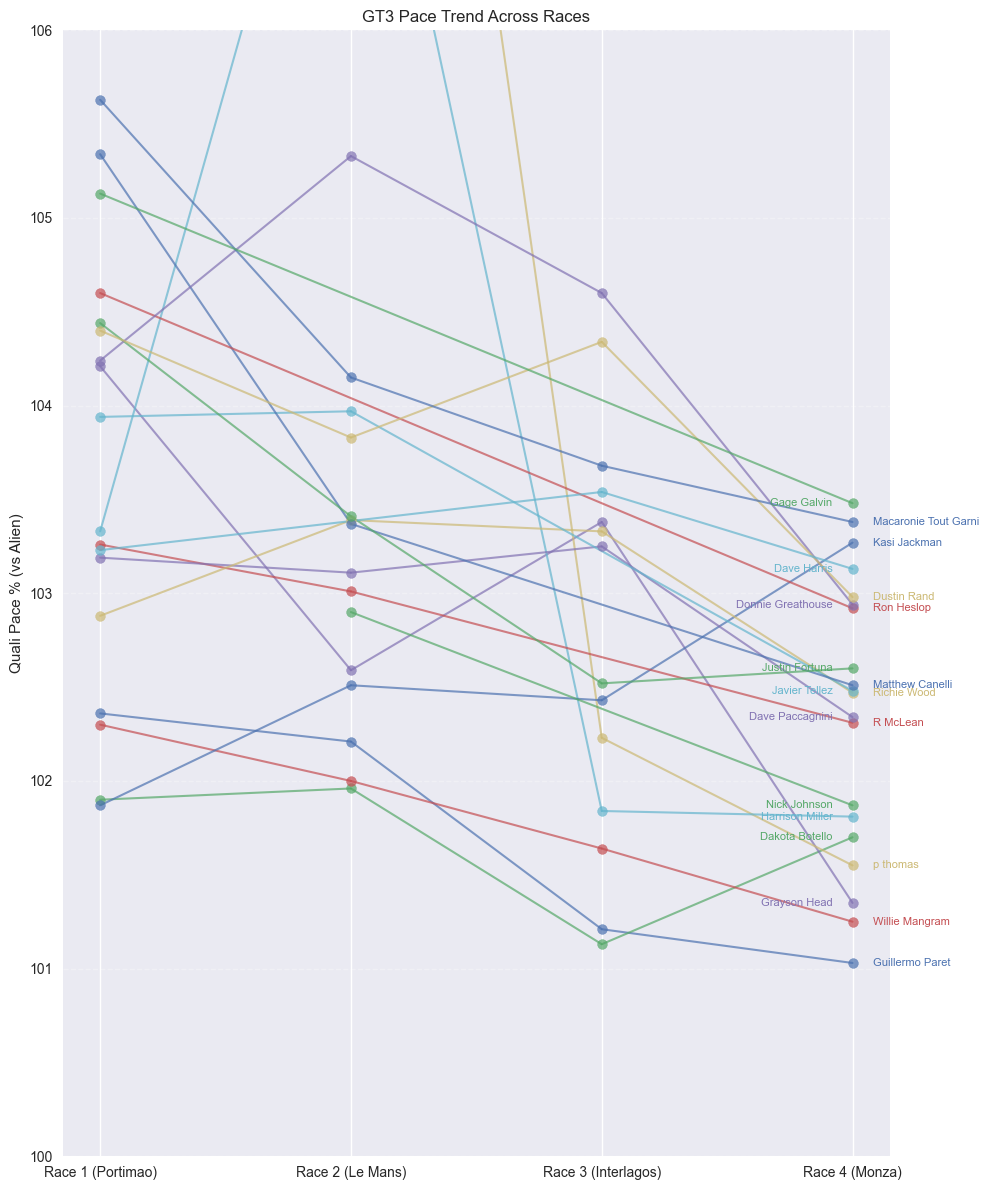

In [11]:
plt.style.use('seaborn-v0_8')

# Prepare GT3 data for visualization
race_cols_gt3 = [col for col in comparison_df_gt3.columns if col.startswith('laptime_pct_alien')]

if len(race_cols_gt3) > 0:
    # Create plot data - filter out drivers with no data
    plot_df_gt3 = comparison_df_gt3[['Driver_name'] + race_cols_gt3].copy()
    plot_df_gt3 = plot_df_gt3.dropna(how='all', subset=race_cols_gt3)
    
    # Calculate best pace for sorting
    plot_df_gt3['best_pace'] = plot_df_gt3[race_cols_gt3].min(axis=1, skipna=True)
    plot_df_gt3 = plot_df_gt3.sort_values('best_pace').reset_index(drop=True)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(10, 12))
    
    race_names = ['Race 1 (Portimao)', 'Race 2 (Le Mans)', 'Race 3 (Interlagos)', 'Race 4 (Monza)'][:len(race_cols_gt3)]
    x_positions = np.arange(len(race_cols_gt3))
    
    for idx, (_, row) in enumerate(plot_df_gt3.iterrows()):
        y_values = [row[col] for col in race_cols_gt3]
        
        # Alternate label placement
        x_offset = 0.08 if idx % 2 == 0 else -0.08
        ha_align = 'left' if idx % 2 == 0 else 'right'
        
        # Get color from first plot call
        temp_line = ax.plot([], [], marker='o', lw=1.5, alpha=0.7, label=row['Driver_name'])
        line_color = temp_line[0].get_color()
        
        # Draw line segments connecting valid (non-NaN) points
        valid_indices = [i for i, v in enumerate(y_values) if not pd.isna(v)]
        for i in range(len(valid_indices) - 1):
            start_idx = valid_indices[i]
            end_idx = valid_indices[i + 1]
            ax.plot([x_positions[start_idx], x_positions[end_idx]], 
                   [y_values[start_idx], y_values[end_idx]], 
                   color=line_color, lw=1.5, alpha=0.7)
        
        # Plot points at all valid positions
        ax.scatter([x_positions[i] for i in valid_indices], 
                  [y_values[i] for i in valid_indices], 
                  color=line_color, s=50, alpha=0.7, zorder=3)
        
        # Find last non-NaN value for label placement
        label_idx = len(y_values) - 1
        for i in range(len(y_values) - 1, -1, -1):
            if not pd.isna(y_values[i]):
                label_idx = i
                break
        
        # Add label at end of line

        ax.text(x_positions[label_idx] + x_offset, y_values[label_idx], row['Driver_name'], va='center', ha=ha_align, fontsize=8, color=line_color)    

    

    ax.set_xticks(x_positions)

    ax.set_xticklabels(race_names)    
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.set_ylabel('Quali Pace % (vs Alien)')
    ax.set_title('GT3 Pace Trend Across Races') 
    plt.ylim(100,106)   
    plt.tight_layout()
    plt.show()

## Step 8: Generate P2UR Pace Trend Visualization

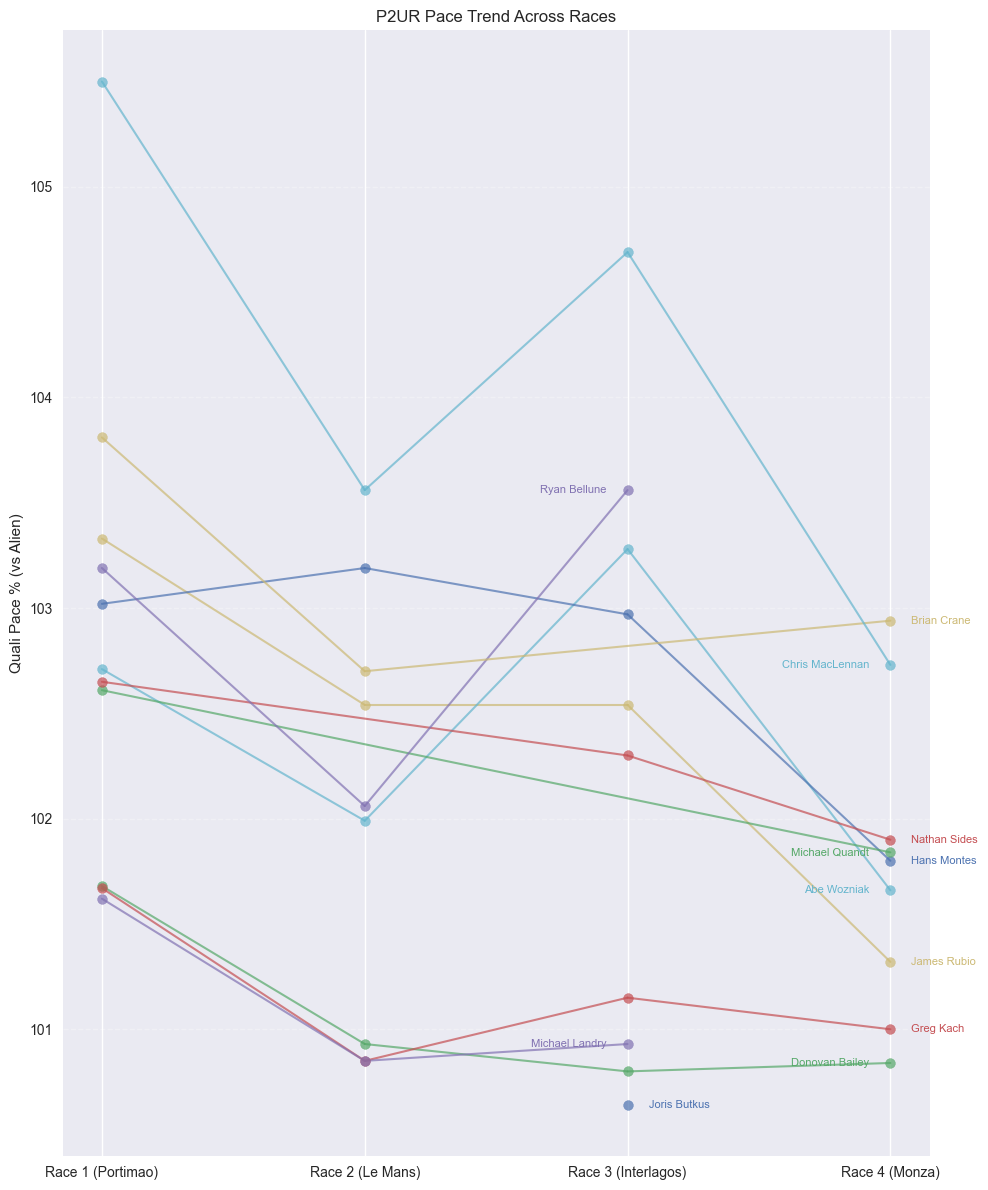

In [12]:
# Prepare P2UR data for visualization
race_cols_p2ur = [col for col in comparison_df_p2ur.columns if col.startswith('laptime_pct_alien')]

if len(race_cols_p2ur) > 0:
    # Create plot data - filter out drivers with no data
    plot_df_p2ur = comparison_df_p2ur[['Driver_name'] + race_cols_p2ur].copy()
    plot_df_p2ur = plot_df_p2ur.dropna(how='all', subset=race_cols_p2ur)
    
    # Calculate best pace for sorting
    plot_df_p2ur['best_pace'] = plot_df_p2ur[race_cols_p2ur].min(axis=1, skipna=True)
    plot_df_p2ur = plot_df_p2ur.sort_values('best_pace').reset_index(drop=True)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(10, 12))
    
    race_names = ['Race 1 (Portimao)', 'Race 2 (Le Mans)', 'Race 3 (Interlagos)', 'Race 4 (Monza)'][:len(race_cols_p2ur)]
    x_positions = np.arange(len(race_cols_p2ur))
    
    for idx, (_, row) in enumerate(plot_df_p2ur.iterrows()):
        y_values = [row[col] for col in race_cols_p2ur]
        
        # Alternate label placement
        x_offset = 0.08 if idx % 2 == 0 else -0.08
        ha_align = 'left' if idx % 2 == 0 else 'right'
        
        # Get color from first plot call
        temp_line = ax.plot([], [], marker='o', lw=1.5, alpha=0.7, label=row['Driver_name'])
        line_color = temp_line[0].get_color()
        
        # Draw line segments connecting valid (non-NaN) points
        valid_indices = [i for i, v in enumerate(y_values) if not pd.isna(v)]
        for i in range(len(valid_indices) - 1):
            start_idx = valid_indices[i]
            end_idx = valid_indices[i + 1]
            ax.plot([x_positions[start_idx], x_positions[end_idx]], 
                   [y_values[start_idx], y_values[end_idx]], 
                   color=line_color, lw=1.5, alpha=0.7)
        
        # Plot points at all valid positions
        ax.scatter([x_positions[i] for i in valid_indices], 
                  [y_values[i] for i in valid_indices], 
                  color=line_color, s=50, alpha=0.7, zorder=3)
        
        # Find last non-NaN value for label placement
        label_idx = len(y_values) - 1
        for i in range(len(y_values) - 1, -1, -1):
            if not pd.isna(y_values[i]):
                label_idx = i
                break
        
        # Add label at end of line
        ax.text(x_positions[label_idx] + x_offset, y_values[label_idx], row['Driver_name'], 
                va='center', ha=ha_align, fontsize=8, color=line_color)
    
    ax.set_xticks(x_positions)
    ax.set_xticklabels(race_names)
    ax.set_ylabel('Quali Pace % (vs Alien)')
    ax.set_title('P2UR Pace Trend Across Races')
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough race data for P2UR visualization")

In [13]:
from datetime import datetime

comparison_df_gt3.to_csv(f'gt3_comparison_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv', index=False)
comparison_df_p2ur.to_csv(f'p2ur_comparison_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv', index=False)

In [14]:
improv_df = comparison_df_gt3[comparison_df_gt3['laptime_pct_alien_mc4'].notna()]
improv_df[['Driver_name', 'laptime_pct_alien_mc1','laptime_pct_alien_mc2', 'laptime_pct_alien_mc3', 'laptime_pct_alien_mc4', 'pace_diff']].sort_values('pace_diff', ascending=False)

,Driver_name,laptime_pct_alien_mc1,laptime_pct_alien_mc2,laptime_pct_alien_mc3,laptime_pct_alien_mc4,pace_diff
6,Grayson Head,104.21,102.59,103.38,101.35,2.86
13,Matthew Canelli,105.34,103.37,NaN,102.51,2.83
12,Macaronie Tout Garni,105.63,104.15,103.68,103.38,2.25
10,Justin Fortuna,104.44,103.41,102.52,102.60,1.84
18,Ron Heslop,104.60,NaN,NaN,102.92,1.68
5,Gage Galvin,105.13,NaN,NaN,103.48,1.65
8,Harrison Miller,103.33,108.06,101.84,101.81,1.52
9,Javier Tellez,103.94,103.97,NaN,102.48,1.46
4,Dustin Rand,104.40,103.83,104.34,102.98,1.42
7,Guillermo Paret,102.36,102.21,101.21,101.03,1.33


In [15]:
improv_df_p2ur = comparison_df_p2ur[comparison_df_p2ur['laptime_pct_alien_mc4'].notna()]
improv_df_p2ur[['Driver_name', 'laptime_pct_alien_mc1','laptime_pct_alien_mc2', 'laptime_pct_alien_mc3', 'laptime_pct_alien_mc4', 'pace_diff']].sort_values('pace_diff', ascending=False)

,Driver_name,laptime_pct_alien_mc1,laptime_pct_alien_mc2,laptime_pct_alien_mc3,laptime_pct_alien_mc4,pace_diff
2,Chris MacLennan,105.50,103.56,104.69,102.73,2.77
7,James Rubio,103.33,102.54,102.54,101.32,2.01
6,Hans Montes,103.02,103.19,102.97,101.80,1.22
0,Abe Wozniak,102.71,101.99,103.28,101.66,1.05
1,Brian Crane,103.81,102.70,NaN,102.94,0.87
4,Donovan Bailey,101.68,100.93,100.80,100.84,0.84
10,Michael Quandt,102.61,NaN,NaN,101.84,0.77
11,Nathan Sides,102.65,NaN,102.30,101.90,0.75
5,Greg Kach,101.67,100.85,101.15,101.00,0.67


C:\Users\nitin\AppData\Local\Temp\ipykernel_10284\3477750396.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(gt3_boxplot_data, labels=['Portimao', 'Le Mans', 'Interlagos', 'Monza'][:len(gt3_boxplot_data)], showfliers=False)
C:\Users\nitin\AppData\Local\Temp\ipykernel_10284\3477750396.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(p2ur_boxplot_data, labels=['Portimao', 'Le Mans', 'Interlagos', 'Monza'][:len(p2ur_boxplot_data)], showfliers=False)


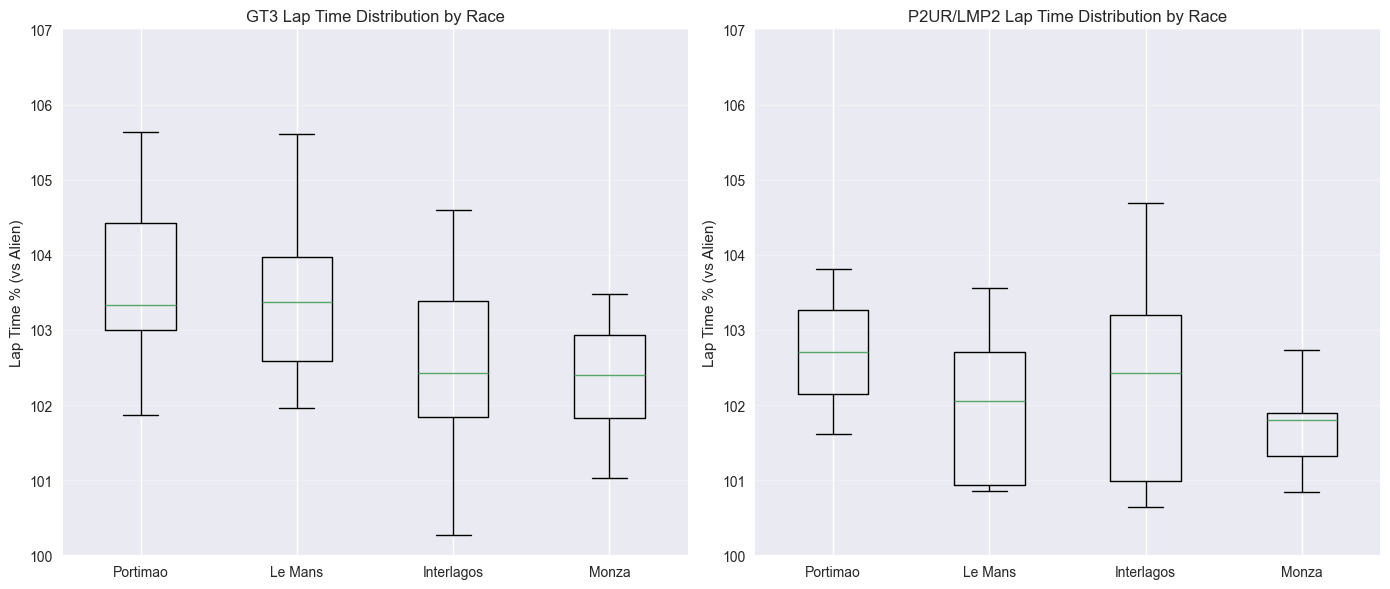

In [19]:
# Create boxplots comparing lap time distributions by race and class

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# GT3 Boxplot
gt3_boxplot_data = [
    df_gt3_mc1[df_gt3_mc1['laptime_pct_alien'] > 0]['laptime_pct_alien'].values,
    df_gt3_mc2[df_gt3_mc2['laptime_pct_alien'] > 0]['laptime_pct_alien'].values if df_gt3_mc2 is not None else [],
    df_gt3_mc3[df_gt3_mc3['laptime_pct_alien'] > 0]['laptime_pct_alien'].values if df_gt3_mc3 is not None else [],
    df_gt3_mc4[df_gt3_mc4['laptime_pct_alien'] > 0]['laptime_pct_alien'].values if df_gt3_mc4 is not None else []
]
gt3_boxplot_data = [data for data in gt3_boxplot_data if len(data) > 0]

axes[0].boxplot(gt3_boxplot_data, labels=['Portimao', 'Le Mans', 'Interlagos', 'Monza'][:len(gt3_boxplot_data)], showfliers=False)
axes[0].set_ylabel('Lap Time % (vs Alien)')
axes[0].set_title('GT3 Lap Time Distribution by Race')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim(100, 107)  # Set y-axis limits for better comparison

# P2UR Boxplot
p2ur_boxplot_data = [
    df_p2ur_mc1[df_p2ur_mc1['laptime_pct_alien'] > 0]['laptime_pct_alien'].values,
    df_p2ur_mc2[df_p2ur_mc2['laptime_pct_alien'] > 0]['laptime_pct_alien'].values if df_p2ur_mc2 is not None else [],
    df_p2ur_mc3[df_p2ur_mc3['laptime_pct_alien'] > 0]['laptime_pct_alien'].values if df_p2ur_mc3 is not None else [],
    df_p2ur_mc4[df_p2ur_mc4['laptime_pct_alien'] > 0]['laptime_pct_alien'].values if df_p2ur_mc4 is not None else []
]
p2ur_boxplot_data = [data for data in p2ur_boxplot_data if len(data) > 0]

axes[1].boxplot(p2ur_boxplot_data, labels=['Portimao', 'Le Mans', 'Interlagos', 'Monza'][:len(p2ur_boxplot_data)], showfliers=False)
axes[1].set_ylabel('Lap Time % (vs Alien)')
axes[1].set_title('P2UR/LMP2 Lap Time Distribution by Race')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim(100, 107)  # Set y-axis limits for better comparison

plt.tight_layout()
plt.show()